In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
sc.settings.verbosity = 0
import scipy
#from numpy.linalg import svd
import gseapy as gp

import warnings
warnings.filterwarnings("ignore")

In [2]:
try:
    from sys import path as syspath
    from os import path as ospath
    syspath.append(ospath.join(ospath.expanduser("~"), 'Documents/git/Xct'))

    from scTenifoldXct.main import *
    import scTenifoldXct.dNN as dNN    
    import scTenifoldXct.visualization as vis
    
except ImportError:
    print('Module not found')

In [4]:
ada1 = sc.read_h5ad("../data/LS_processed.h5ad")
ada1

AnnData object with n_obs × n_vars = 5011 × 3000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'patient.id', 'condition', 'labels', 'ident'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    layers: 'log1p', 'raw'

In [5]:
ada2 = sc.read_h5ad("../data/NL_matched.h5ad")
ada2

AnnData object with n_obs × n_vars = 2552 × 3000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'patient.id', 'condition', 'labels', 'ident'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    layers: 'log1p', 'raw'

In [6]:
ada1.obs['ident'].value_counts()

APOE+ FIB       1228
FBN1+ FIB        813
TC               765
CD40LG+ TC       630
Inflam. FIB      484
cDC2             294
Inflam. TC       266
COL11A1+ FIB     181
cDC1             121
Inflam. DC        81
NKT               81
LC                67
Name: ident, dtype: int64

In [7]:
ada2.obs['ident'].value_counts()

APOE+ FIB       1215
FBN1+ FIB        548
TC               212
COL11A1+ FIB     196
CD40LG+ TC       166
Inflam. FIB       69
Inflam. TC        44
cDC2              38
NKT               36
LC                20
cDC1               7
Inflam. DC         1
Name: ident, dtype: int64

## LS & NL obj:

In [ ]:
# obj1 = Xct(ada1, 'Inflam. FIB', 'Inflam. TC', build_GRN = True, save_GRN = True,
#            pcNet_name = 'net_FIB2TC_LS', mode = 'full', verbose = True)

# obj1 = Xct(ada1, 'Inflam. FIB', 'Inflam. TC', build_GRN = False,
#            pcNet_name = 'net_FIB2TC_LS', mode = 'full', verbose = True)
# print(obj1)

In [8]:
# obj1 = Xct(ada1, 'Inflam. TC', 'Inflam. FIB', build_GRN = True, save_GRN = True,
#            pcNet_name = 'net_TC2FIB_LS', mode = 'full', verbose = True)

obj1 = Xct(ada1, 'Inflam. TC', 'Inflam. FIB', build_GRN = False,
           pcNet_name = 'net_TC2FIB_LS', mode = 'full', verbose = True)

print(obj1)

init an Xct object for interactions from Inflam. TC (266) to Inflam. FIB (484)...
loading GRNs...
building correspondence...
init completed.

Xct object for interactions from Inflam. TC (266) to Inflam. FIB (484)
# of genes = 3000 X 3000 
Correspondence = 6000 X 6000


In [9]:
df1 = obj1.fill_metric()
len(df1)

267

In [ ]:
# obj2 = Xct(ada2, 'Inflam. FIB', 'Inflam. TC', build_GRN = True, save_GRN = True,
#            pcNet_name = 'net_FIB2TC_NL', mode = 'full', verbose = True)

# obj2 = Xct(ada2, 'Inflam. FIB', 'Inflam. TC', build_GRN = False,
#            pcNet_name = 'net_FIB2TC_NL', mode = 'full', verbose = True)

# print(obj2)

In [10]:
# obj2 = Xct(ada2, 'Inflam. TC', 'Inflam. FIB', build_GRN = True, save_GRN = True,
#            pcNet_name = 'net_TC2FIB_NL_matched', mode = 'full', verbose = True)

obj2 = Xct(ada2, 'Inflam. TC', 'Inflam. FIB', build_GRN = False,
           pcNet_name = 'net_TC2FIB_NL_matched', mode = 'full', verbose = True)

print(obj2)

init an Xct object for interactions from Inflam. TC (44) to Inflam. FIB (69)...
loading GRNs...
building correspondence...
init completed.

Xct object for interactions from Inflam. TC (44) to Inflam. FIB (69)
# of genes = 3000 X 3000 
Correspondence = 6000 X 6000


In [11]:
df2 = obj2.fill_metric()
len(df2)

61

In [12]:
#selected LR pairs
candidates1 = get_candidates(df1)
print(len(candidates1))

candidates2 = get_candidates(df2)
print(len(candidates2))

267
61


In [13]:
candidates_union = list(set(candidates1).union(set(candidates2)))
len(candidates_union)

274

In [14]:
candidates_inter = list(set(candidates1).intersection(set(candidates2)))
len(candidates_inter)

54

In [15]:
obj1._w.shape, obj2._w.shape

((6000, 6000), (6000, 6000))

In [16]:
counts_np1 = get_counts_np(obj1, obj2)
len(counts_np1), counts_np1[0].shape, counts_np1[1].shape, counts_np1[2].shape, counts_np1[3].shape

(4, (3000, 266), (3000, 484), (3000, 44), (3000, 69))

In [17]:
W = build_W(obj1, obj2)
W.shape

(12000, 12000)

In [18]:
projections, losses = dNN.train_and_project(counts_np1, w = W, dim = 2, steps = 1000, lr = 0.01)

Net(
  (linear1): Linear(in_features=266, out_features=92, bias=True)
  (linear2): Linear(in_features=92, out_features=23, bias=True)
  (linear3): Linear(in_features=23, out_features=2, bias=True)
)
Net(
  (linear1): Linear(in_features=484, out_features=124, bias=True)
  (linear2): Linear(in_features=124, out_features=31, bias=True)
  (linear3): Linear(in_features=31, out_features=2, bias=True)
)
Net(
  (linear1): Linear(in_features=44, out_features=36, bias=True)
  (linear2): Linear(in_features=36, out_features=9, bias=True)
  (linear3): Linear(in_features=9, out_features=2, bias=True)
)
Net(
  (linear1): Linear(in_features=69, out_features=44, bias=True)
  (linear2): Linear(in_features=44, out_features=11, bias=True)
  (linear3): Linear(in_features=11, out_features=2, bias=True)
)
1 15422.0791015625
100 765.2332763671875
200 740.4804077148438
300 737.267822265625
400 735.4185791015625
500 734.1935424804688
600 733.1241455078125
700 732.196044921875
800 731.263916015625
900 730.318603

In [19]:
projections.shape

(12000, 2)

In [20]:
projections_split = np.array_split(projections, 2) #return a list of ndarray
projections_split[0].shape, projections_split[1].shape

((6000, 2), (6000, 2))

In [21]:
df_nn1 = nn_aligned_dist(obj1, projections_split[0])
df_nn2 = nn_aligned_dist(obj2, projections_split[1])

df_nn1.head()

computing pair-wise distances...
manifold aligned # of pairs: 9000000
adding column 'rank'...
adding column 'correspondence_score'...
computing pair-wise distances...
manifold aligned # of pairs: 9000000
adding column 'rank'...
adding column 'correspondence_score'...


,idx,dist,rank,correspondence_score
LCP1_CD74,"(2374, 2991)",0.000001,1,74.586082
FAM129A_PDGFRB,"(671, 1681)",0.000001,2,63.082496
IL26_MYL12A,"(2191, 12)",0.000002,3,71.392059
IL27RA_SLIT3,"(32, 1411)",0.000002,4,60.683307
CCL1_MRC2,"(2997, 1123)",0.000002,5,149.821986


In [22]:
df_nn2.head()

,idx,dist,rank,correspondence_score
IL22_ZFP36L2,"(2984, 787)",0.000002,1,94.489889
IL7R_ABI3BP,"(2723, 1882)",0.000003,2,80.483848
ARL4C_TCF4,"(1260, 1105)",0.000003,3,80.806924
DOCK8_LRP1,"(832, 2323)",0.000004,4,103.573300
SYNRG_DPT,"(640, 421)",0.000004,5,55.047956


In [23]:
df_nn_all = nn_aligned_dist_diff(df_nn1, df_nn2)
#df_nn_all = pd.concat([df_nn1, df_nn2], axis=1) 

df_nn_all

,idx,dist,rank,correspondence_score,idx,dist,rank,correspondence_score,diff2,diff2_rank
PIDD1_CHRDL1,"(380, 343)",0.018945,4988199,1.219414e-03,"(380, 343)",0.004711,179002,8.336180e+00,2.026091e-04,1
PIDD1_LINC00310,"(380, 325)",0.020175,6017179,1.330552e-25,"(380, 325)",0.006379,285143,5.775640e+00,1.903433e-04,2
PIDD1_HSD17B13,"(380, 2177)",0.019874,5713647,4.209993e-04,"(380, 2177)",0.006207,272830,5.080838e+00,1.868069e-04,3
TTC21B_CHRDL1,"(654, 343)",0.019230,5200938,1.257914e-03,"(654, 343)",0.005985,258013,5.088678e+00,1.754330e-04,4
KLF12_CHRDL1,"(529, 343)",0.019296,5249752,2.100016e-03,"(529, 343)",0.006195,272046,3.832970e+00,1.716415e-04,5
...,...,...,...,...,...,...,...,...,...,...
LOC101927070_GBP5,"(934, 1722)",0.017258,3964690,7.772667e-02,"(934, 1722)",0.017258,3836952,2.201613e-24,3.122502e-17,8999996
NBPF20_GBP5,"(1694, 1722)",0.017258,3964689,7.772667e-02,"(1694, 1722)",0.017258,3839406,2.201613e-24,3.122502e-17,8999997
C2CD4D_ERO1B,"(449, 636)",0.014286,2536913,1.799758e-01,"(449, 636)",0.014286,2537441,2.453626e-01,3.122502e-17,8999998
PBX4_MMP12,"(642, 2995)",0.015131,2911864,1.476425e-01,"(642, 2995)",0.015131,2911325,4.263768e-24,1.387779e-17,8999999


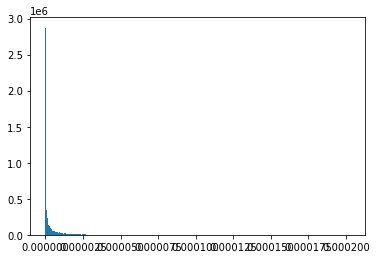

In [25]:
plt.hist(df_nn_all['diff2'], bins=1000)
plt.show()

In [27]:
df_enriched_diff = chi2_diff_test(df_nn_all, df=1, FDR=False, candidates=candidates_union)
df_enriched_diff


Total enriched: 44 / 9000000


,idx,dist,rank,correspondence_score,idx,dist,rank,correspondence_score,diff2,diff2_rank,p_val,enriched_rank
AREG_ROR2,"(2807, 285)",0.007996,430681,4.824863e+00,"(2807, 285)",0.015187,2933747,3.812425e-24,0.000052,24618,0.000327,1
S100A8_CD69,"(2766, 2943)",0.014334,2557792,4.148415e-01,"(2766, 2943)",0.021489,6868293,1.156615e-47,0.000051,26801,0.000351,2
DCN_VEGFA,"(2992, 825)",0.009932,844261,1.434995e+00,"(2992, 825)",0.016580,3528338,2.493275e-24,0.000044,46566,0.000897,3
CXCL13_ACKR1,"(2939, 1705)",0.015209,2945249,1.723166e-01,"(2939, 1705)",0.021489,6472091,1.156615e-47,0.000039,66802,0.001702,4
GDF11_ACVR2A,"(887, 570)",0.013993,2409555,3.219748e-24,"(887, 570)",0.007741,395467,1.280032e+00,0.000039,68529,0.001788,5
CCL22_ACKR1,"(2937, 1705)",0.015292,2986022,1.609616e-01,"(2937, 1705)",0.021489,6468679,1.156615e-47,0.000038,72855,0.001961,6
S100A8_ITGB2,"(2766, 491)",0.015464,3069605,5.911797e-02,"(2766, 491)",0.021489,6787842,1.156615e-47,0.000036,86502,0.002611,7
IGF1_ROR2,"(2776, 285)",0.015669,3163815,1.207536e-01,"(2776, 285)",0.021489,6875019,1.156615e-47,0.000034,109832,0.003643,8
TNFSF9_HLA-DPA1,"(798, 2987)",0.015686,3169232,2.540831e-01,"(798, 2987)",0.021489,8437248,1.156615e-47,0.000034,111227,0.003738,9
IL9_IL2RG,"(2968, 2026)",0.015780,3221524,1.424064e-01,"(2968, 2026)",0.021489,6313778,1.156615e-47,0.000033,121591,0.004340,10


#### GSEA:

In [28]:
genelist = get_genelist(df_enriched_diff)
len(genelist)

47

In [30]:
import gseapy as gp

enr = gp.enrichr(gene_list= genelist,
                 gene_sets='GO_Biological_Process_2021',
                 organism='Human', 
                 outdir=None, #'enrichr_kegg',
                 no_plot=True,
                 cutoff=0.05 
                )

In [31]:
enr.results.head()

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2021,positive regulation of phosphorylation (GO:004...,13/253,1.496902e-14,1.663058e-11,0,0,31.405515,999.725266,DDR1;TFRC;MUSK;IGF1;MERTK;ACVR2A;VEGFA;FGF7;IF...
1,GO_Biological_Process_2021,inflammatory response (GO:0006954),11/230,4.430917e-12,1.853489e-09,0,0,27.533486,719.791793,CXCL10;CCL22;IFNG;IL9;ITGB2;CCL4;CXCR4;CCR7;AC...
2,GO_Biological_Process_2021,cytokine-mediated signaling pathway (GO:0019221),15/621,6.091263e-12,1.853489e-09,0,0,14.965192,386.463594,CNTFR;CCL22;ITGB2;OSM;CXCL13;IL2RG;VEGFA;CXCL1...
3,GO_Biological_Process_2021,positive regulation of cellular process (GO:00...,15/625,6.673229e-12,1.853489e-09,0,0,14.863986,382.493714,NOTCH1;OSM;IGF1;MERTK;IL2RG;AREG;DLL1;VEGFA;FG...
4,GO_Biological_Process_2021,enzyme linked receptor protein signaling pathw...,9/140,3.383212e-11,7.517497e-09,0,0,35.837284,864.022960,DDR1;MUSK;ROR2;MERTK;ACVR1B;ACVR2A;EPHA3;FGFR2...


https://maayanlab.cloud/Enrichr/enrich?dataset=983557128e2439ce19c24f8a2ea1ed2b

#### visualization:

In [32]:
Xct.add_names_to_nets(obj1)
Xct.add_names_to_nets(obj2)

completed.
completed.


In [33]:
targets = vis.get_Xct_pairs(df_enriched_diff)
targets

(['AREG', 'ROR2'],
 ['S100A8', 'CD69'],
 ['DCN', 'VEGFA'],
 ['CXCL13', 'ACKR1'],
 ['GDF11', 'ACVR2A'],
 ['CCL22', 'ACKR1'],
 ['S100A8', 'ITGB2'],
 ['IGF1', 'ROR2'],
 ['TNFSF9', 'HLA-DPA1'],
 ['IL9', 'IL2RG'],
 ['VEGFA', 'EPHA3'],
 ['CXCL13', 'CXCR4'],
 ['CCL4', 'CCR6'],
 ['CCL22', 'CXCR4'],
 ['GDF11', 'ACVR1B'],
 ['VEGFA', 'S1PR1'],
 ['CXCL14', 'CXCR4'],
 ['CXCL13', 'CCR6'],
 ['CCL4', 'CCR10'],
 ['VEGFA', 'FGFR2'],
 ['CCL22', 'CCR6'],
 ['POSTN', 'PTK7'],
 ['CRLF1', 'CNTFR'],
 ['CCL4', 'CCR7'],
 ['CXCL14', 'CCR6'],
 ['VEGFA', 'DDR1'],
 ['AREG', 'PTK7'],
 ['FGF7', 'ROR2'],
 ['CXCL13', 'CCR10'],
 ['AREG', 'MERTK'],
 ['CCL22', 'CCR10'],
 ['OSM', 'CXCL10'],
 ['CXCL13', 'CCR7'],
 ['CCL22', 'CCR7'],
 ['CXCL14', 'CCR10'],
 ['AREG', 'MUSK'],
 ['CXCL14', 'CCR7'],
 ['IFNG', 'TFRC'],
 ['VEGFA', 'EPHB4'],
 ['OSM', 'LDLR'],
 ['IGF1', 'PLXNA3'],
 ['DLL1', 'NOTCH1'],
 ['JAG2', 'NOTCH3'],
 ['SEMA5A', 'PLXNA3'])

In [ ]:
# targets_inter = set(df_enriched_diff.index).intersection(set(candidates_inter))
# targets_inter = [pair.split('_') for pair in targets_inter]

# targets_inter

In [36]:
scale_factor = 10

identified 216 TF(s) along with 1 ligand/receptor target gene(s)
undirected graph constructed: 
# of nodes: 21, # of edges: 20

identified 216 TF(s) along with 1 ligand/receptor target gene(s)
undirected graph constructed: 
# of nodes: 21, # of edges: 20

graphs merged: 
# of nodes: 42, # of edges: 40

edge from VEGFA to FGFR2 added


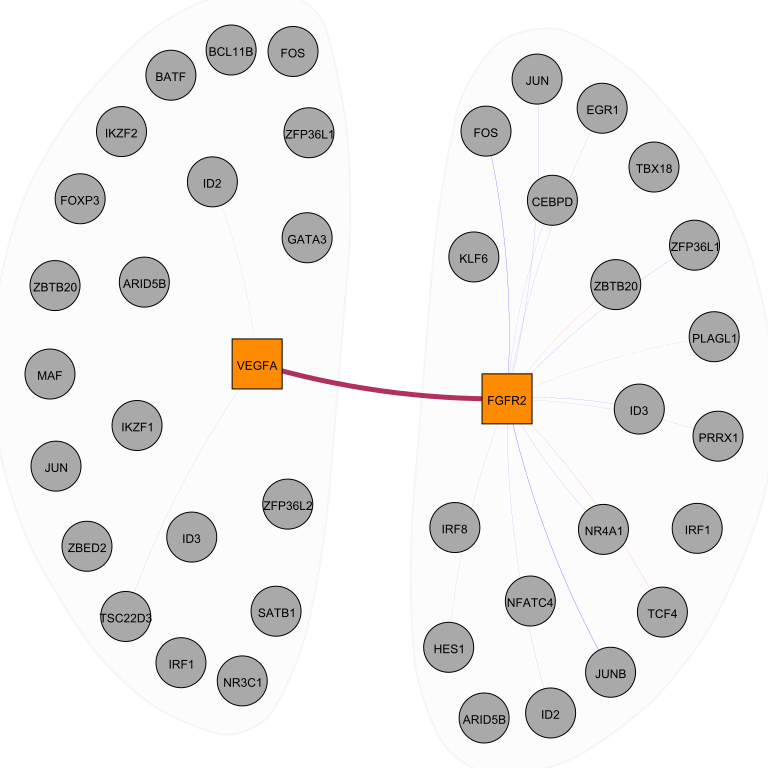

In [39]:
import random
random.seed(0)

g1 = vis.plot_pcNet(obj1, view='sender', gene_names=[targets[19][0]], top_edges=20, show = False, verbose = True)
g2 = vis.plot_pcNet(obj1, view='receiver', gene_names=[targets[19][1]], top_edges=20, show = False, verbose = True)

vis.plot_XNet(g1, g2, Xct_pair = [targets[19]], verbose = True, edge_width_scale=scale_factor)

identified 216 TF(s) along with 1 ligand/receptor target gene(s)
undirected graph constructed: 
# of nodes: 21, # of edges: 20

identified 216 TF(s) along with 1 ligand/receptor target gene(s)
undirected graph constructed: 
# of nodes: 21, # of edges: 20

graphs merged: 
# of nodes: 42, # of edges: 40

edge from VEGFA to FGFR2 added


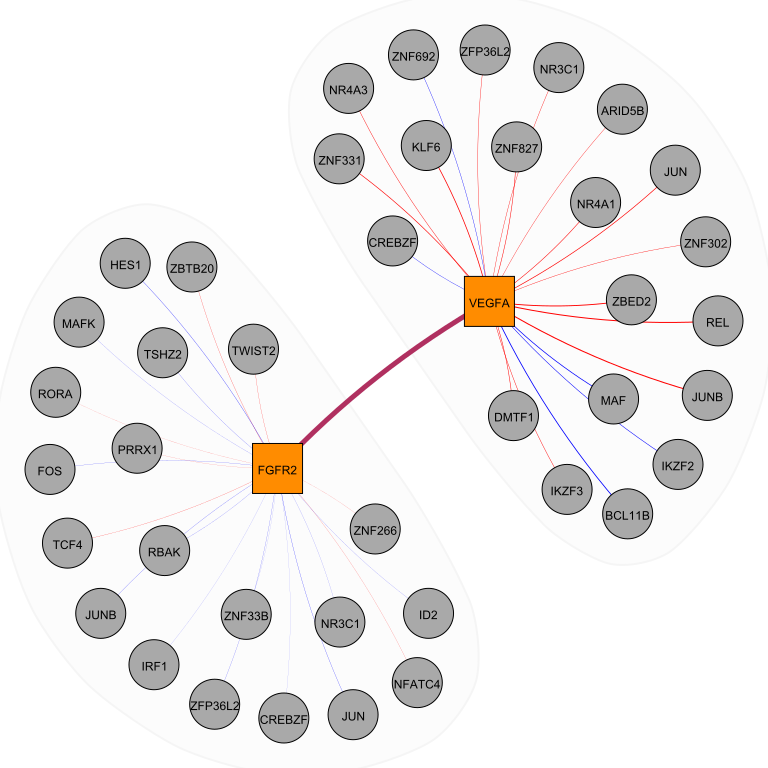

In [42]:
g1 = vis.plot_pcNet(obj2, view='sender', gene_names=[targets[19][0]], top_edges=20, show = False, verbose = True)
g2 = vis.plot_pcNet(obj2, view='receiver', gene_names=[targets[19][1]], top_edges=20, show = False, verbose = True)

vis.plot_XNet(g1, g2, Xct_pair = [targets[19]], verbose = True, edge_width_scale=scale_factor)